In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
from scipy import stats
from sklearn.linear_model import ElasticNet, Lasso, Ridge, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from scipy.special import boxcox1p
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.svm import SVR, LinearSVR

In [ ]:
!pip install --quiet optuna

In [ ]:
import optuna

optuna.__version__

'2.2.0'

In [ ]:
#import train and test set. 
df_train = pd.read_csv('/content/gdrive/My Drive/House Pricing/train.csv')
df_test = pd.read_csv('/content/gdrive/My Drive/House Pricing/test.csv')

In [ ]:
#Train and test set info
print(f"Train set contains {df_train.shape}\nTest set contains {df_test.shape}")

Train set contains (1460, 81)
Test set contains (1459, 80)


In [ ]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# **Log Transformation on SalePrice**

---



Skewness of the target class is 1.8828757597682129


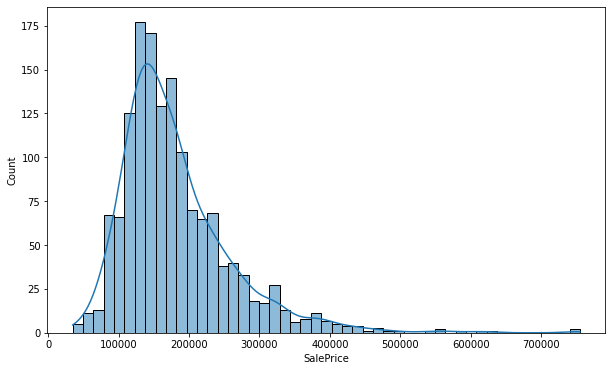

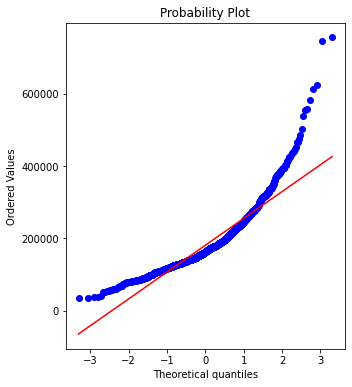

In [ ]:
#Target Class Skewness before Transformation 
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df_train['SalePrice'], kde=True, ax = ax)
print(f"Skewness of the target class is {df_train['SalePrice'].skew()}")
#Target Class qqplot before Transformation 
plt.figure(figsize=(5, 6))
res = stats.probplot(df_train['SalePrice'], plot= plt)
plt.show()

Skewness of the target class is 0.12134661989685333


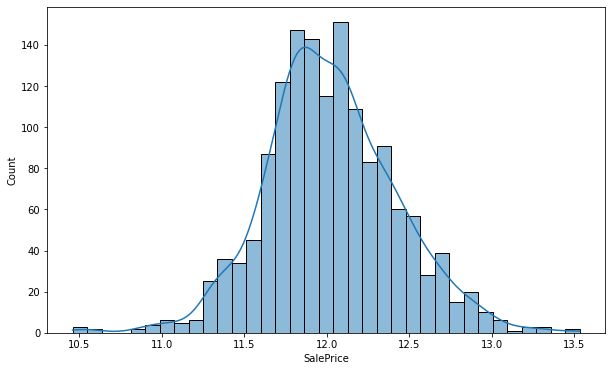

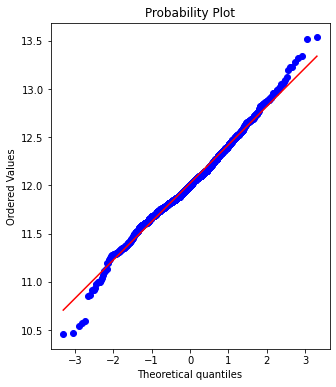

In [ ]:
#Log Transform the Target Class
lognorm = np.log1p(df_train['SalePrice'])
#Target Class Skewness after Transformation 
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(lognorm, kde=True, ax = ax)
print(f"Skewness of the target class is {lognorm.skew()}")
#Target Class qqplot after Transformation 
plt.figure(figsize=(5, 6))
res = stats.probplot(lognorm, plot= plt)
plt.show()

# **Data Correlation**

---



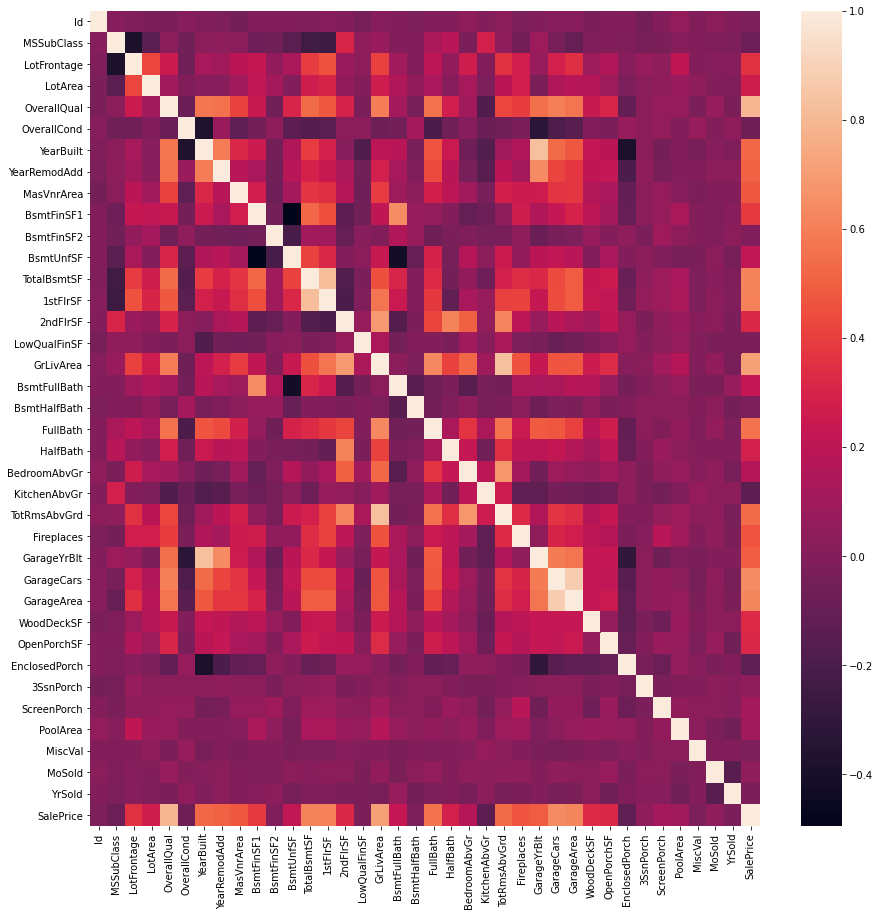

In [ ]:
#Build a Heatmap to examine the correlations bewteen different features 
corr = df_train.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=False)

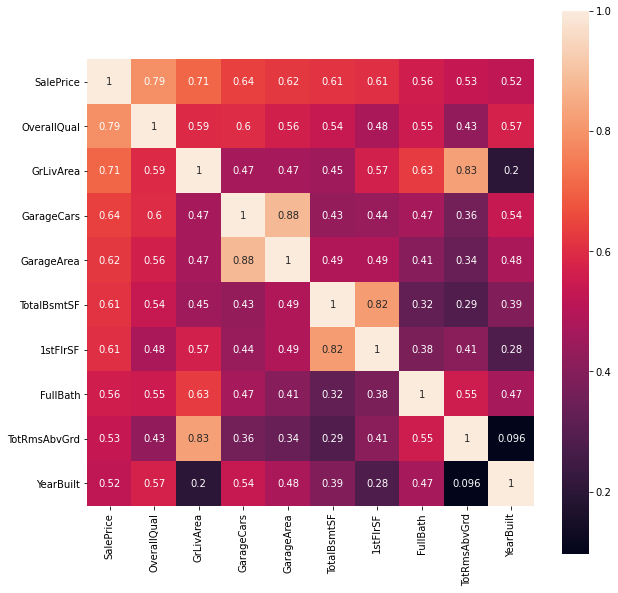

In [ ]:
#Zoomed Heatmap Top 10
large_idx = corr.nlargest(10, 'SalePrice').index 
top_rows = corr.loc[large_idx, large_idx]
plt.figure(figsize=(10, 10))
sns.heatmap(top_rows, annot=True, square=True)


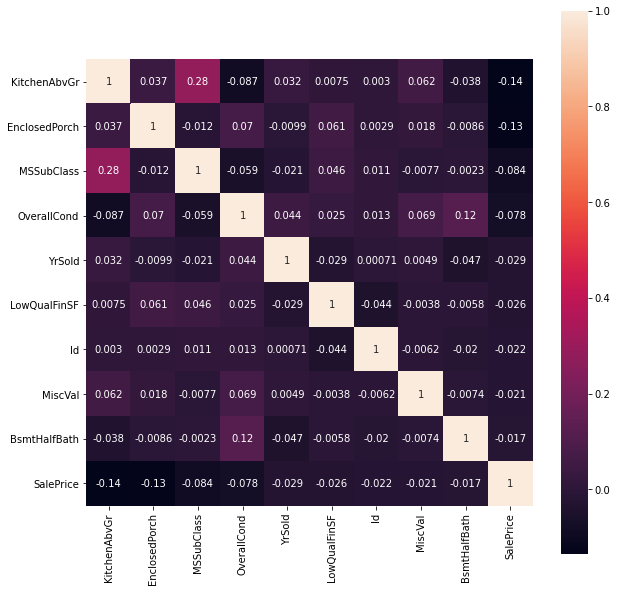

In [ ]:
#Zoomed Heatmap Smallest 10
small_idx = corr.nsmallest(9, 'SalePrice').index.tolist()
small_idx.append('SalePrice')
small_rows = corr.loc[small_idx, small_idx]
plt.figure(figsize=(10, 10))
sns.heatmap(small_rows, annot=True, square=True)

# **Missing Data**

---



PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageCond      0.055479
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
BsmtExposure    0.026027
BsmtFinType2    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
Utilities       0.000000
dtype: float64


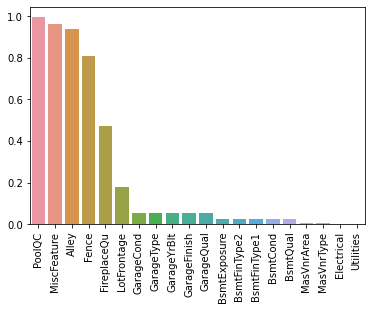

In [ ]:
#Fill in missing values 
null_ratio = df_train.isnull().sum()/len(df_train.index)
null_ratio = null_ratio.sort_values(ascending = False).head(20)
plt.xticks(rotation='90')
sns.barplot(x = null_ratio.index, y = null_ratio)
print(null_ratio)

PoolQC          0.997944
MiscFeature     0.965045
Alley           0.926662
Fence           0.801234
FireplaceQu     0.500343
LotFrontage     0.155586
GarageCond      0.053461
GarageQual      0.053461
GarageYrBlt     0.053461
GarageFinish    0.053461
GarageType      0.052090
BsmtCond        0.030843
BsmtQual        0.030158
BsmtExposure    0.030158
BsmtFinType1    0.028787
BsmtFinType2    0.028787
MasVnrType      0.010966
MasVnrArea      0.010281
MSZoning        0.002742
BsmtHalfBath    0.001371
Utilities       0.001371
Functional      0.001371
BsmtFullBath    0.001371
BsmtFinSF2      0.000685
BsmtFinSF1      0.000685
Exterior2nd     0.000685
BsmtUnfSF       0.000685
TotalBsmtSF     0.000685
SaleType        0.000685
Exterior1st     0.000685
dtype: float64


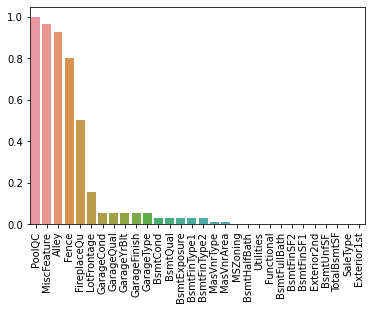

In [ ]:
#Fill in missing values 
null_ratio = df_test.isnull().sum()/len(df_test.index)
null_ratio = null_ratio.sort_values(ascending = False).head(30)
plt.xticks(rotation='90')
sns.barplot(x = null_ratio.index, y = null_ratio)
print(null_ratio)

*Impute PoolQC*

In [ ]:

#Fill the missing values in PoolQC with None
df_train['PoolQC'] = df_train['PoolQC'].fillna('None')
df_test['PoolQC'] = df_test['PoolQC'].fillna('None')

*Impute MiscFeature*

In [ ]:
#Fill the missing values in MiscFeature with None
df_train['MiscFeature'] = df_train['MiscFeature'].fillna('None')
df_test['MiscFeature'] = df_test['MiscFeature'].fillna('None')

*Impute Alley*

In [ ]:
#Fill the missing values in Alley with None
df_train['Alley'] = df_train['Alley'].fillna('None')
df_test['Alley'] = df_test['Alley'].fillna('None')

*Impute Fence*

In [ ]:
#Fill the missing values in Fence with None
df_train['Fence'] = df_train['Fence'].fillna('None')
df_test['Fence'] = df_test['Fence'].fillna('None')

*Impute FireplaceQu*

In [ ]:
#Fill the missing values in FirepaceQu with None
df_train['FireplaceQu'] = df_train['FireplaceQu'].fillna('None')
df_test['FireplaceQu'] = df_test['FireplaceQu'].fillna('None')

*Impute LogFrontage*

In [ ]:
#Groupby Train Neighborhood
df_train.groupby('Neighborhood')[['LotFrontage']].agg(['median', 'count'])

LotFrontage      
                  median count
Neighborhood                  
Blmngtn             43.0    14
Blueste             24.0     2
BrDale              21.0    16
BrkSide             52.0    51
ClearCr             80.0    13
CollgCr             70.0   126
Crawfor             74.0    41
Edwards             65.5    92
Gilbert             65.0    49
IDOTRR              60.0    34
MeadowV             21.0    15
Mitchel             73.0    36
NAmes               73.0   186
NPkVill             24.0     7
NWAmes              80.0    45
NoRidge             91.0    33
NridgHt             88.5    76
OldTown             60.0   109
SWISU               60.0    23
Sawyer              71.0    48
SawyerW             66.5    50
Somerst             73.5    78
StoneBr             61.5    20
Timber              85.0    30
Veenker             68.0     7

In [ ]:
#Groupby train LotArea
df_train['LotAreaCut'] = pd.qcut(df_train['LotArea'], 10)
df_train.groupby('LotAreaCut')[['LotFrontage']].agg(['median', 'count'])

LotFrontage      
                         median count
LotAreaCut                           
(1299.999, 5000.0]         35.0   123
(5000.0, 7078.4]           52.0   127
(7078.4, 8063.7]           61.0   123
(8063.7, 8793.4]           65.0   133
(8793.4, 9478.5]           70.5   122
(9478.5, 10198.2]          76.0   129
(10198.2, 11066.5]         75.0   123
(11066.5, 12205.8]         84.5   114
(12205.8, 14381.7]         85.0   108
(14381.7, 215245.0]        90.0    99

In [ ]:
#Impute train LotFrontage
df_train['LotFrontage'] = df_train.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
df_train['LotFrontage'].isnull().sum()


0

In [ ]:
#Groupby test LotArea
df_test['LotAreaCut'] = pd.qcut(df_test['LotArea'], 10)
df_test.groupby('LotAreaCut')[['LotFrontage']].agg(['median', 'count'])

LotFrontage      
                        median count
LotAreaCut                          
(1469.999, 4793.0]        32.0   127
(4793.0, 6958.4]          52.0   138
(6958.4, 7843.8]          61.0   131
(7843.8, 8640.0]          65.0   125
(8640.0, 9399.0]          70.0   118
(9399.0, 10125.8]         75.0   128
(10125.8, 10940.2]        76.0   129
(10940.2, 12194.4]        80.5   112
(12194.4, 14259.0]        85.0   119
(14259.0, 56600.0]        90.0   105

In [ ]:
#Impute test LotFrontage
df_test['LotFrontage'] = df_test.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
df_test['LotFrontage'].isnull().sum()

0

Impute MSSubClass

In [ ]:
#Fill the missing values in MSSubClass with None
df_train['MSSubClass'] = df_train['MSSubClass'].fillna('None')
df_test['MSSubClass'] = df_test['MSSubClass'].fillna('None')

*Impute GarageX Features*

In [ ]:
#Fill the missing values in Garage-related features with None and 0
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    df_train[col] = df_train[col].fillna('None')
    df_test[col] = df_test[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df_train[col] = df_train[col].fillna(0)
    df_test[col] = df_test[col].fillna(0)

*Impute BasementX Features*

In [ ]:
#Fill the missing values in Basement-related features with None and 0
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df_train[col] = df_train[col].fillna(0)
    df_test[col] = df_test[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df_train[col] = df_train[col].fillna('None')
    df_test[col] = df_test[col].fillna('None')

*Impute MaxVnr Features*

In [ ]:
#Fill the missing values in MaxVnr-related features with None and 0
df_train['MasVnrType'] = df_train['MasVnrType'].fillna('None')
df_test['MasVnrType'] = df_test['MasVnrType'].fillna('None')
df_train['MasVnrArea'] = df_train['MasVnrArea'].fillna(0)
df_test['MasVnrArea'] = df_test['MasVnrArea'].fillna(0)

*Impute MSZoning, Functional, Electrical, KitchenQual, Exterior, SaleType, MSSubClass*

In [ ]:
#Fill the missing values in MSZoning with RL
for col in ['MSZoning', 'Functional', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'MSSubClass']:
  df_train[col] = df_train[col].fillna(df_train[col].mode()[0])
  df_test[col] = df_test[col].fillna(df_test[col].mode()[0])

*Test Missing Values*

In [ ]:
print(f'Number of Missing Values in the training set: {df_train.isnull().sum().sum()}')
print(f'Number of Missing Values in the testing set: {df_train.isnull().sum().sum()}')

Number of Missing Values in the training set: 0
Number of Missing Values in the testing set: 0


# **Feature Engineering**

*Map certain categorical features*

In [ ]:
#Concat test set and train set together
all_data = pd.concat([df_train, df_test]).drop(['LotAreaCut', 'Id'], axis = 1, errors= 'ignore')
print(all_data.shape)
all_data

(2919, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500.0
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500.0
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500.0
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000.0
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,None,None,0.0,None,0.0,0.0,None,None,Y,0,0,0,0,0,0,None,None,None,0,6,2006,WD,Normal,NaN
1455,160,RM,21.0,1894,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,None,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,None,None,None,0,4,2006,WD,Abnorml,NaN
1456,20,RL,160.0,20000,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,None,None,None,0,9,2006,WD,Abnorml,NaN
1457,85,RL,62.0,10441,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitch

In [ ]:
#Convert the features to str type
for x in ['MSSubClass','MoSold', 'YrSold', "YearBuilt","YearRemodAdd", "GarageYrBlt"]:
  all_data[x] = all_data[x].apply(str)


In [ ]:
#Get the numeric and categorical columns. 
numeric = all_data.select_dtypes(include='number').columns
categorical = all_data.select_dtypes(exclude= 'number').columns
print(numeric, categorical)

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'SalePrice'],
      dtype='object') Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '

In [ ]:
#Neighborhood and SalePrice
all_data.groupby(by='Neighborhood')['SalePrice'].agg(['median', 'mean']).sort_values(by='median', ascending = False)

,median,mean
Neighborhood,,
NridgHt,315000.0,316270.623377
NoRidge,301500.0,335295.317073
StoneBr,278000.0,310499.000000
Timber,228475.0,242247.447368
Somerst,225500.0,225379.837209
Veenker,218000.0,238772.727273
Crawfor,200624.0,210624.725490
ClearCr,200250.0,212565.428571
CollgCr,197200.0,197965.773333


In [ ]:
#MSZoning and SalePrice
all_data.groupby(by='MSZoning')['SalePrice'].agg(['median', 'mean']).sort_values(by='median', ascending = False)

,median,mean
MSZoning,,
FV,205950.0,214014.061538
RL,174000.0,191004.994787
RH,136500.0,131558.375000
RM,120500.0,126316.830275
C (all),74700.0,74528.000000


In [ ]:
#Map some categorical features with values 
# to_do = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'KitchenQual', 'HeatingQC', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish', 'PavedDrive']
# all_data['ExterQual'] = all_data['ExterQual'].map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
# all_data['ExterCond'] = all_data['ExterCond'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
# all_data['BsmtQual'] = all_data['BsmtQual'].map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
# all_data['BsmtCond'] = all_data['BsmtCond'].map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
# all_data['BsmtExposure'] = all_data['BsmtExposure'].map({'None':1, 'No':2, 'Mn':3, 'Av':4, 'Gd':5})
# all_data['KitchenQual'] = all_data['KitchenQual'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
# all_data['HeatingQC'] = all_data['HeatingQC'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
# all_data['FireplaceQu'] = all_data['FireplaceQu'].map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
# all_data['GarageQual'] = all_data['GarageQual'].map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
# all_data['GarageCond'] = all_data['GarageCond'].map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
# all_data['PoolQC'] = all_data['PoolQC'].map({'None':2, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
# all_data['Fence'] = all_data['Fence'].map({'None': 2, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4})
# all_data['BsmtFinType1'] = all_data['BsmtFinType1'].map({'None':1, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
# all_data['BsmtFinType2'] = all_data['BsmtFinType2'].map({'None':3, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
# all_data['Functional'] = all_data['Functional'].map({'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7})
# all_data['GarageFinish'] = all_data['GarageFinish'].map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})
# all_data['PavedDrive'] = all_data['PavedDrive'].map({'N':1, 'P':2, 'Y':3})
# all_data['MSZoning'] = all_data['MSZoning'].map({'C (all)': 1, 'RM': 2, 'RH': 3, 'RL': 4, 'FV': 5})
# all_data['num_Neighborhood'] = all_data['Neighborhood'].map({'MeadowV': 1, 
#                                                              'IDOTRR': 2, 'BrDale': 2, 
#                                                              'OldTown': 3, 'Edwards': 3, 'BrkSide': 3,
#                                                              'Sawyer': 4, 'Blueste': 4,
#                                                              'SWISU': 5, 'NAmes': 5, 'NPkVill':5,
#                                                              'Mitchel': 6,
#                                                              'SawyerW': 7, 'Gilbert': 7, 'NWAmes': 7, 
#                                                              'CollgCr': 8, 'ClearCr': 8, 'Crawfor': 8, 'Blmngtn': 8,
#                                                              'Veenker': 9, 'Somerst': 9, 'Timber': 9,
#                                                              'StoneBr': 10, 'NoRidge': 10, 'NridgHt': 10  
#                                                              })


# all_data.select_dtypes(exclude= 'number')

In [ ]:
#Map some categorical features with values 
to_do = ['num_ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'KitchenQual', 'HeatingQC', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish', 'PavedDrive']
all_data['num_ExterQual'] = all_data['ExterQual'].map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
all_data['num_ExterCond'] = all_data['ExterCond'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
all_data['num_BsmtQual'] = all_data['BsmtQual'].map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
all_data['num_BsmtCond'] = all_data['BsmtCond'].map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
all_data['num_BsmtExposure'] = all_data['BsmtExposure'].map({'None':1, 'No':2, 'Mn':3, 'Av':4, 'Gd':5})
all_data['num_KitchenQual'] = all_data['KitchenQual'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
all_data['num_HeatingQC'] = all_data['HeatingQC'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
all_data['num_FireplaceQu'] = all_data['FireplaceQu'].map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
all_data['num_GarageQual'] = all_data['GarageQual'].map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
all_data['num_GarageCond'] = all_data['GarageCond'].map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
all_data['num_PoolQC'] = all_data['PoolQC'].map({'None':2, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
all_data['num_Fence'] = all_data['Fence'].map({'None': 2, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4})
all_data['num_BsmtFinType1'] = all_data['BsmtFinType1'].map({'None':1, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
all_data['num_BsmtFinType2'] = all_data['BsmtFinType2'].map({'None':3, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
all_data['num_Functional'] = all_data['Functional'].map({'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7})
all_data['num_GarageFinish'] = all_data['GarageFinish'].map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})
all_data['num_PavedDrive'] = all_data['PavedDrive'].map({'N':1, 'P':2, 'Y':3})
all_data['num_MSZoning'] = all_data['MSZoning'].map({'C (all)': 1, 'RM': 2, 'RH': 3, 'RL': 4, 'FV': 5})
all_data['num_Neighborhood'] = all_data['Neighborhood'].map({'MeadowV': 1, 
                                                             'IDOTRR': 2, 'BrDale': 2, 
                                                             'OldTown': 3, 'Edwards': 3, 'BrkSide': 3,
                                                             'Sawyer': 4, 'Blueste': 4,
                                                             'SWISU': 5, 'NAmes': 5, 'NPkVill':5,
                                                             'Mitchel': 6,
                                                             'SawyerW': 7, 'Gilbert': 7, 'NWAmes': 7, 
                                                             'CollgCr': 8, 'ClearCr': 8, 'Crawfor': 8, 'Blmngtn': 8,
                                                             'Veenker': 9, 'Somerst': 9, 'Timber': 9,
                                                             'StoneBr': 10, 'NoRidge': 10, 'NridgHt': 10  
                                                             })

all_data["num_Condition1"] = all_data['Condition1'].map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})
all_data["num_MSSubClass"] = all_data['MSSubClass'].map({'180':1, 
                                        '30':2, '45':2, 
                                        '190':3, '50':3, '90':3, 
                                        '85':4, '40':4, '160':4, 
                                        '70':5, '20':5, '75':5, '80':5, '150':5,
                                        '120': 6, '60':6})
# all_data.select_dtypes(include= 'number')

In [ ]:
# #Feature Crossing 
# all_data['allFlrSF'] = all_data["1stFlrSF"] + all_data["2ndFlrSF"]
# all_data['QualCond'] = all_data['OverallQual'] * all_data['OverallCond'] 

# all_data['RmsAbvGrd'] = all_data["TotRmsAbvGrd"] + all_data['FullBath']
# all_data['PorchArea'] = all_data["OpenPorchSF"] + all_data["EnclosedPorch"] + all_data["3SsnPorch"] + all_data["ScreenPorch"]
# all_data["TotalPlace"] = all_data["TotalBsmtSF"] + all_data["1stFlrSF"] + all_data["2ndFlrSF"] + all_data["GarageArea"] + all_data["OpenPorchSF"] + all_data["EnclosedPorch"] + all_data["3SsnPorch"] + all_data["ScreenPorch"]
# all_data['QualAll'] = all_data['num_ExterQual'] * all_data['num_KitchenQual'] * all_data['OverallQual'] * all_data['num_GarageQual'] * all_data['GrLivArea'] * all_data['num_Neighborhood']
# all_data['QualArea'] = all_data['OverallQual'] * all_data['TotalPlace']


In [ ]:
#Feature Crossing 
# all_data['allFlrSF'] = all_data["1stFlrSF"] + all_data["2ndFlrSF"]
# all_data['QualCond'] = all_data['OverallQual'] * all_data['OverallCond'] 

# all_data['RmsAbvGrd'] = all_data["TotRmsAbvGrd"] + all_data['FullBath']
# all_data['PorchArea'] = all_data["OpenPorchSF"] + all_data["EnclosedPorch"] + all_data["3SsnPorch"] + all_data["ScreenPorch"]
# all_data["TotalPlace"] = all_data["TotalBsmtSF"] + all_data["1stFlrSF"] + all_data["2ndFlrSF"] + all_data["GarageArea"] + all_data["OpenPorchSF"] + all_data["EnclosedPorch"] + all_data["3SsnPorch"] + all_data["ScreenPorch"]
# all_data['QualAll'] = all_data['ExterQual'] * all_data['KitchenQual'] * all_data['OverallQual'] * all_data['GarageQual'] * all_data['GrLivArea'] * all_data['num_Neighborhood']
# all_data['QualArea'] = all_data['OverallQual'] * all_data['TotalPlace']

In [ ]:
#Label encode some categorical features 
for x in ['YrSold', "YearBuilt","YearRemodAdd", "GarageYrBlt"]:
  le = preprocessing.LabelEncoder()
  all_data[x] = le.fit_transform(all_data[x])
all_data.select_dtypes(include= 'number')

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,SalePrice,num_ExterQual,num_ExterCond,num_BsmtQual,num_BsmtCond,num_BsmtExposure,num_KitchenQual,num_HeatingQC,num_FireplaceQu,num_GarageQual,num_GarageCond,num_PoolQC,num_Fence,num_BsmtFinType1,num_BsmtFinType2,num_Functional,num_GarageFinish,num_PavedDrive,num_MSZoning,num_Neighborhood,num_Condition1,num_MSSubClass
0,65.0,8450,7,5,110,53,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,95,2.0,548.0,0,61,0,0,0,0,0,2,208500.0,3,3,5,4,2,4,5,1,4,4,2,2,6,1,7,3,3,4,8,3,6
1,80.0,9600,6,8,83,26,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,68,2.0,460.0,298,0,0,0,0,0,0,1,181500.0,2,3,5,4,5,3,5,4,4,4,2,2,5,1,7,3,3,4,9,2,5
2,68.0,11250,7,5,108,52,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,93,2.0,608.0,0,42,0,0,0,0,0,2,223500.0,3,3,5,4,3,4,5,4,4,4,2,2,6,1,7,3,3,4,8,3,6
3,60.0,9550,7,5,25,20,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,90,3.0,642.0,0,35,272,0,0,0,0,0,140000.0,2,3,4,5,2,4,4,5,4,4,2,2,5,1,7,2,3,4,8,3,5
4,84.0,14260,8,5,107,50,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,92,3.0,836.0,192,84,0,0,0,0,0,2,250000.0,3,3,5,4,4,4,5,4,4,4,2,2,6,1,7,3,3,4,10,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,21.0,1936,4,7,77,20,0.0,0.0,0.0,546.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,5,0,0,0.0,0.0,0,0,0,0,0,0,0,0,NaN,2,3,4,4,2,3,4,1,1,1,2,2,1,1,7,1,3,2,1,3,4
1455,21.0,1894,4,5,77,20,0.0,252.0,0.0,294.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,6,0,62,1.0,286.0,0,24,0,0,0,0,0,0,NaN,2,3,4,4,2,3,3,1,4,4,2,2,3,1,7,2,3,2,1,3,4
1456,160.0,20000,5,7,67,46,0.0,1224.0,0.0,0.0,1224.0,1224,0,0,1224,1.0,0.0,1,0,4,1,7,1,52,2.0,576.0,474,0,0,0,0,0,0,0,NaN,2,3,4,4,2,3,5,4,4,4,2,2,5,1,7,2,3,4,6,3,5
1457,62.0,10441,5,5,99,42,0.0,337.0,0.0,575.0,912.0,970,0,0,970,0.0,1.0,1,0,3,1,6,0,0,0.0,0.0,80,32,0,0,0,0,700,0,NaN,2,3,5,4,4,3,3,1,1,1,2,3,6,1,7,1,3,4,6,3,4


In [ ]:
X = all_data
X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
X["+_oMSZoning_TotalHouse"] = X["num_MSZoning"] * X["TotalHouse"]
X["+_oMSZoning_OverallQual"] = X["num_MSZoning"] + X["OverallQual"]
X["+_oMSZoning_YearBuilt"] = X["num_MSZoning"] + X["YearBuilt"]
X["+_oNeighborhood_TotalHouse"] = X["num_Neighborhood"] * X["TotalHouse"]
X["+_oNeighborhood_OverallQual"] = X["num_Neighborhood"] + X["OverallQual"]
X["+_oNeighborhood_YearBuilt"] = X["num_Neighborhood"] + X["YearBuilt"]
X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]

X["-_oFunctional_TotalHouse"] = X["num_Functional"] * X["TotalHouse"]
X["-_oFunctional_OverallQual"] = X["num_Functional"] + X["OverallQual"]
X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
X["-_oCondition1_TotalHouse"] = X["num_Condition1"] * X["TotalHouse"]
X["-_oCondition1_OverallQual"] = X["num_Condition1"] + X["OverallQual"]


X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
# X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]


In [ ]:
all_data = X

In [ ]:
#Examine the correlations bewteen different features 
corr = all_data.corr()
corr['SalePrice'].sort_values(ascending = False).head(40)


SalePrice                      1.000000
+_oNeighborhood_TotalHouse     0.881285
+_TotalHouse_OverallQual       0.856148
+_GrLivArea_OverallQual        0.832057
TotalArea                      0.809561
OverallQual                    0.790982
-_oFunctional_TotalHouse       0.784069
+_oNeighborhood_OverallQual    0.783178
TotalHouse                     0.782260
+_oMSZoning_TotalHouse         0.771839
-_oCondition1_OverallQual      0.767515
+_oMSZoning_OverallQual        0.763273
-_oCondition1_TotalHouse       0.745078
-_oFunctional_OverallQual      0.722625
GrLivArea                      0.708624
num_ExterQual                  0.682639
num_Neighborhood               0.681744
num_KitchenQual                0.659600
GarageCars                     0.640409
GarageArea                     0.623431
Bsmt                           0.613581
TotalBsmtSF                    0.613581
1stFlrSF                       0.605852
Rooms                          0.592733
num_BsmtQual                   0.585207


*Check the skewness of data*

In [ ]:
#Find the skewed features. 
numeric = all_data.select_dtypes(include='number').columns
categorical = all_data.select_dtypes(exclude= 'number').columns
skewness = []
for col in numeric: 
  skewness.append([col, all_data[col].skew()])
skewness = pd.DataFrame(data=skewness).rename({0:'Column', 1:'Skewness'}, axis = 1).set_index('Column')
skewed = skewness.loc[(skewness['Skewness'] > 1) | (skewness['Skewness'] < -1)].index 
# skewness.sort_values(by='Skewness', ascending = False)

In [ ]:
#Transform the skewed features. 
lam = 0.15
for col in skewed:
  all_data[col] = boxcox1p(all_data[col], lam)

In [ ]:
#Test the transformed columns. 
skewness = []
for col in numeric: 
  skewness.append([col, all_data[col].skew()])
skewness = pd.DataFrame(data=skewness).rename({0:'Column', 1:'Skewness'}, axis = 1).set_index('Column')
# skewness.sort_values(by='Skewness', ascending = False)

In [ ]:
all_data = all_data.drop(['SalePrice'], axis=1)

*One-Hot Encoding*

In [ ]:
#Get dummies of the dataframe
all_data_dummy = pd.get_dummies(all_data, drop_first=True)

In [ ]:
all_data_dummy.shape

(2919, 324)

# **Feature Selection**

In [ ]:
#Split to train and test sets
X_train = all_data_dummy.loc[:1459, :]
X_test = all_data_dummy.iloc[1460:, :]
Y_train = lognorm

In [ ]:
# #Select K best features
# f_selector = SelectKBest(score_func=f_regression, k='all')
# f_selector.fit(X_train, Y_train)
# # transform train input data
# X_train_fs = f_selector.transform(X_train)
# # transform test input data
# X_test_fs = f_selector.transform(X_test)
# # Plot the scores for the features
# feat_score = pd.DataFrame(f_selector.scores_, X_train.columns, columns=['Score']).sort_values(by='Score', ascending =False)
# feat_top = feat_score[feat_score > 0]
# plt.figure(figsize=(20,35))
# sns.barplot(y=feat_top.index, x='Score', data=feat_top, orient='h')


In [ ]:
#PCA
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
pca_train = PCA(n_components = 0.95)
pca_train.fit(X_train_scaled)
X_train_transformed = pca_train.transform(X_train_scaled)
pca_test = PCA(n_components = 0.95)
pca_test.fit(X_test_scaled)
X_test_transformed = pca_test.transform(X_test_scaled)
print(X_train_transformed.shape, X_test_transformed.shape)

(1460, 112) (1459, 109)


# Modelling

In [ ]:
#Cross-validated rmsle score.
def rmsle_cv(model):
    kf = KFold(10, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, Y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

*Lasso Regression*

In [ ]:
#Lasso Regression score
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=42, max_iter=10000))
lasso_score = rmsle_cv(lasso)
lasso_score.mean()

0.11759869591672592

In [ ]:
#Optuna tuned Lasso Regression score
def objective(trial):

    _alpha = trial.suggest_float("alpha", 0.0001, 0.01)
    _maxiter = trial.suggest_float('max_iter', 5000, 15000)
    _tol = trial.suggest_float('tol', 0.0001, 0.1)

    lasso = make_pipeline(RobustScaler(), Lasso(alpha=_alpha, random_state=42, max_iter=_maxiter, tol=_tol))

    score = rmsle_cv(lasso).mean()
    return score


optuna.logging.set_verbosity(0)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

lasso_params = study.best_params
lasso_best_score = study.best_value
print(f"Best score:{lasso_best_score} \nOptimized parameters: {lasso_params}")

Best score:0.11539097351738552 
Optimized parameters: {'alpha': 0.0002392508019238667, 'max_iter': 9462.447359276159, 'tol': 0.012354275714386933}


In [ ]:
lasso_temp = lasso
lasso_temp.fit(X_train, Y_train)

FI_lasso = pd.DataFrame({"FI":lasso_temp[1].coef_}, index=X_train.columns).sort_values(by='FI', ascending = False)
FI_lasso.head(30)

,FI
num_MSZoning,0.326003
+_oNeighborhood_TotalHouse,0.269760
TotalArea,0.097775
+_oMSZoning_OverallQual,0.096509
SaleType_New,0.078167
GrLivArea,0.077601
MSZoning_RM,0.075732
-_oFunctional_TotalHouse,0.065571
+_oMSZoning_YearBuilt,0.065204
Neighborhood_BrkSide,0.063507


*Ridge Regression*

In [ ]:
#Ridge Regression score
ridge = make_pipeline(RobustScaler(), Ridge())
ridge_score = rmsle_cv(ridge)
ridge_score.mean()

0.11981730999337978

In [ ]:
#Optuna tuned Ridge Regression score
def objective(trial):

    _alpha = trial.suggest_float("alpha", 0.01, 100)
    _tol = trial.suggest_float("tol", 0.0001, 0.9)

    ridge = make_pipeline(RobustScaler(), Ridge(alpha=_alpha, tol=_tol))

    score = rmsle_cv(ridge).mean()
    return score


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

ridge_params = study.best_params
ridge_best_score = study.best_value
print(f"Best score:{ridge_best_score} \nOptimized parameters: {ridge_params}")

Best score:0.11895055758038611 
Optimized parameters: {'alpha': 2.587130374094105, 'tol': 0.8069446049756173}


In [ ]:
ridge_temp = Ridge(**ridge_params)
ridge_temp.fit(X_train, Y_train)

FI_ridge = pd.DataFrame({"FI":ridge_temp.coef_}, index=X_train.columns).sort_values(by='FI', ascending = False)
FI_ridge.head(20)

,FI
Functional,0.054410
Neighborhood_BrkSide,0.050343
SaleCondition_Normal,0.045713
Condition1_Norm,0.043289
TotalPlace,0.040007
CentralAir_Y,0.036720
Exterior1st_BrkFace,0.035821
MSZoning,0.035623
GarageCars,0.034622
SaleType_New,0.034612


*Gradient Boosting Regression*

In [ ]:
#Gradient Boosting Regression score
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
GB_score = rmsle_cv(GBoost)
GB_score.mean()

0.11897436150006897

*Random Forest Regression*

In [ ]:
#Random Forest Regression Score
RF = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)
RF_score = rmsle_cv(RF)
RF_score.mean()

0.13492665456604155

In [ ]:
#Optuna tuned Ridge Regression score
def objective(trial):

    _n_estimators = trial.suggest_float("n_estimators", 0.01, 100)
    _max_depth = trial.suggest_float("max_depth", 6, 30)
    

    ridge = make_pipeline(RobustScaler(), Ridge(alpha=_alpha, tol=_tol))

    score = rmsle_cv(ridge).mean()
    return score


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

ridge_params = study.best_params
ridge_best_score = study.best_value
print(f"Best score:{ridge_best_score} \nOptimized parameters: {ridge_params}")

*Support Vector Regression*

In [ ]:
#Support Vector Regression score
svr = make_pipeline(RobustScaler(), SVR(C= 15, epsilon= 0.008, gamma=0.0003))
svr_score = rmsle_cv(svr)
svr_score.mean()

0.11999834200063175

In [ ]:
#Optuna tuned Ridge Regression score
def objective(trial):

    _C = trial.suggest_float("C", 1, 25)
    _epsilon = trial.suggest_float("epsilon", 0.0001, 0.01)
    _gamma = trial.suggest_float('gamma', 0.00001, 0.001)
    

    ridge = make_pipeline(RobustScaler(), SVR(C=_C, epsilon=_epsilon, gamma=_gamma))

    score = rmsle_cv(ridge).mean()
    return score


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

SVR_params = study.best_params
SVR_best_score = study.best_value
print(f"Best score:{SVR_best_score} \nOptimized parameters: {SVR_params}")

Best score:0.11881427570278147 
Optimized parameters: {'C': 2.1030952227104653, 'epsilon': 0.007829496577643598, 'gamma': 0.0009693993824715651}


In [ ]:
SVR

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('svr',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma='scale', kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)